In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 22.8 MB/s eta 0:00:00


In [ ]:
!pip install numpy==1.26.4   # 혹시 충돌 나면 대비

ERROR: Operation cancelled by user


In [2]:
# 이 zip 파일(Nails_detection.v3i.coco-segmentation.zip)은
#   ✔ 손톱 영역이 polygon segmentation 형식으로 라벨링되어 있고
#   ✔ YOLO 학습에 필요한 COCO annotation이 포함되어 있으며
#   ✔ 우리가 직접 세그멘테이션 라벨링을 하지 않아도 되는
#      고품질 공개 데이터셋이기 때문에 사용함.
#
# 따라서 이 코드는 모델 학습 준비를 위해 반드시 필요한
# **데이터셋 압축 해제 단계**임.

zip_path = "/content/drive/MyDrive/최종프로젝트 /4조 파이널 프로젝트/학습에 필요한 파일/손톱영역_세그멘테이션_모델/폴리곤txt수정/Nails_detection.v3i.yolov11.zip"

# 압축 풀 폴더
extract_path = "/content/nail_dataset"

import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("압축 해제 완료:", extract_path)


압축 해제 완료: /content/nail_dataset


In [4]:
import os

root = "/content/nail_dataset"

splits = ["train", "valid", "test"]

for split in splits:
    img_dir = os.path.join(root, split, "images")
    label_dir = os.path.join(root, split, "labels")

    imgs = sorted([f.split('.')[0] for f in os.listdir(img_dir) if f.endswith(('.jpg','.png','.jpeg'))])
    labels = sorted([f.split('.')[0] for f in os.listdir(label_dir) if f.endswith('.txt')])

    print(f"\n=== {split} ===")
    print("이미지 수:", len(imgs))
    print("라벨 수:", len(labels))

    missing_labels = [i for i in imgs if i not in labels]
    missing_imgs   = [l for l in labels if l not in imgs]

    print("라벨 없는 이미지:", missing_labels[:5])
    print("이미지 없는 라벨:", missing_imgs[:5])



=== train ===
이미지 수: 7923
라벨 수: 7923
라벨 없는 이미지: []
이미지 없는 라벨: []

=== valid ===
이미지 수: 626
라벨 수: 626
라벨 없는 이미지: []
이미지 없는 라벨: []

=== test ===
이미지 수: 752
라벨 수: 752
라벨 없는 이미지: []
이미지 없는 라벨: []


In [5]:
import os
from pathlib import Path
import hashlib
from PIL import Image
import imagehash
import cv2

dataset_root = "/content/nail_dataset"   # 여기를 원하는 경로로 수정!

# =========================================================
# 1) 바이트 동일한 이미지 제거 (hashlib MD5)
# =========================================================
print("📌 1) 바이트 중복 검사 시작")

image_paths = []
for sub in ["train", "valid", "test"]:
    img_dir = Path(dataset_root) / sub
    image_paths.extend(list(img_dir.glob("*.jpg")))

print("총 이미지 수:", len(image_paths))

hash_dict = {}
byte_duplicates = []

for img_path in image_paths:
    try:
        with open(img_path, "rb") as f:
            file_hash = hashlib.md5(f.read()).hexdigest()
    except:
        print("⚠️ 읽기 불가 → 삭제:", img_path)
        os.remove(img_path)
        continue

    if file_hash in hash_dict:
        byte_duplicates.append(img_path)
    else:
        hash_dict[file_hash] = img_path

print("바이트 동일 중복:", len(byte_duplicates))

# 삭제
for dup in byte_duplicates:
    print("🗑 삭제됨:", dup)
    os.remove(dup)

    # 라벨도 삭제
    label_path = dup.with_suffix(".txt")
    if label_path.exists():
        os.remove(label_path)

print("✔ 바이트 중복 제거 완료\n")

# =========================================================
# 2) 이미지-라벨 동기화 (짝 안 맞는 파일 제거)
# =========================================================
print("📌 2) 이미지-라벨 매칭 검사 시작")

for sub in ["train", "valid", "test"]:
    img_dir = Path(dataset_root) / sub
    imgs = {p.stem for p in img_dir.glob("*.jpg")}
    labels = {p.stem for p in img_dir.glob("*.txt")}

    no_label = imgs - labels
    no_image = labels - imgs

    print(f"\n=== {sub} ===")
    print("라벨 없는 이미지:", len(no_label))
    print("이미지 없는 라벨:", len(no_image))

    # 라벨 없는 이미지 제거
    for stem in no_label:
        img_path = img_dir / f"{stem}.jpg"
        print("🗑 이미지 삭제:", img_path)
        img_path.unlink(missing_ok=True)

    # 이미지 없는 라벨 제거
    for stem in no_image:
        label_path = img_dir / f"{stem}.txt"
        print("🗑 라벨 삭제:", label_path)
        label_path.unlink(missing_ok=True)

print("✔ 이미지-라벨 동기화 완료\n")

# =========================================================
# 3) 깨진 이미지 제거 (openCV)
# =========================================================
print("📌 3) 깨진 이미지 검사 시작")

all_images = list(Path(dataset_root).rglob("*.jpg"))
broken_count = 0

for img_path in all_images:
    img = cv2.imread(str(img_path))
    if img is None:
        print("⚠️ 깨진 이미지 삭제:", img_path)
        img_path.unlink()
        broken_count += 1

print("깨진 이미지 수:", broken_count)
print("✔ 깨진 이미지 제거 완료\n")

# =========================================================
# 4) 시각적으로 유사한 이미지 제거 (phash)
# =========================================================
print("📌 4) 시각적 중복 제거 시작 (phash)")

# 최신 이미지 리스트 다시 모으기
all_images = list(Path(dataset_root).rglob("*.jpg"))

phash_dict = {}
vis_duplicates = []
SIMILARITY = 5  # phash 거리 임계값 (5~8 설정 추천)

def find_similar(ph):
    for h in phash_dict:
        if abs(ph - h) <= SIMILARITY:
            return phash_dict[h]
    return None

for img_path in all_images:
    try:
        img = Image.open(img_path)
        ph = imagehash.phash(img)
    except:
        print("⚠️ 읽기 불가 → 삭제:", img_path)
        img_path.unlink()
        continue

    dup = find_similar(ph)
    if dup:
        vis_duplicates.append((img_path, dup))
    else:
        phash_dict[ph] = img_path

print("시각적 중복 수:", len(vis_duplicates))

# 삭제
for img, keep in vis_duplicates:
    print(f"🗑 삭제됨: {img.name} (기준: {keep.name})")
    img.unlink()

    # 해당 라벨 삭제
    lbl = img.with_suffix(".txt")
    if lbl.exists():
        lbl.unlink()

print("✔ 시각적 중복 제거 완료\n")

print("🎉 전체 전처리 완료!")


📌 1) 바이트 중복 검사 시작
총 이미지 수: 0
바이트 동일 중복: 0
✔ 바이트 중복 제거 완료

📌 2) 이미지-라벨 매칭 검사 시작

=== train ===
라벨 없는 이미지: 0
이미지 없는 라벨: 0

=== valid ===
라벨 없는 이미지: 0
이미지 없는 라벨: 0

=== test ===
라벨 없는 이미지: 0
이미지 없는 라벨: 0
✔ 이미지-라벨 동기화 완료

📌 3) 깨진 이미지 검사 시작
깨진 이미지 수: 0
✔ 깨진 이미지 제거 완료

📌 4) 시각적 중복 제거 시작 (phash)
시각적 중복 수: 2974
🗑 삭제됨: 1038_png_jpg.rf.619de28f9db81a1773eaf3d6b7e8cf8c.jpg (기준: 1038_png_jpg.rf.a9bd168f79a010e4c56fc86ddabd987e.jpg)
🗑 삭제됨: 1074_png_jpg.rf.36bb3c191da9afbda2e0097869fa50e8.jpg (기준: 1074_png_jpg.rf.fd9eeecab9306a1f8d0136d38e342964.jpg)
🗑 삭제됨: 1585_png_jpg.rf.0a92daaf8a9897c8037e4dcd98b010b6.jpg (기준: 1585_png_jpg.rf.e3914469b6a6304cc8a9372d8ac3b256.jpg)
🗑 삭제됨: 37_PNG_jpg.rf.59d783606f61c87e3d347686f1529107.jpg (기준: 37_PNG_jpg.rf.22f600707f5c1b8c80375a212e508dce.jpg)
🗑 삭제됨: 114_png_jpg.rf.77a21a425dc1ad8a900f2157db425db0.jpg (기준: 114_png_jpg.rf.50ea5af16ccfe66c975723453b21960d.jpg)
🗑 삭제됨: 1350_png_jpg.rf.2c1704af21b9a938d37b9b49745ff7ea.jpg (기준: 1350_png_jpg.rf.e8cd00b050ebd8259dd43693a

In [ ]:
#전처리한 이미지데이터셋 저장. 추후 전처리 하지말고 이 파일로 쓰기.
from google.colab import drive
import shutil
import os

# 1) 구글 드라이브 마운트
drive.mount('/content/drive')

# 2) 압축할 폴더
src_folder = "/content/nail_dataset"

# 3) 저장될 zip 파일 경로 (원하는 이름으로 바꿔도 됨)
zip_path = "/content/drive/MyDrive/nail_dataset_cleaned.zip"

# 4) 폴더 → ZIP 압축
print("📦 압축 생성 중...")
shutil.make_archive(zip_path.replace('.zip', ''), 'zip', src_folder)

print("🎉 압축 완료!")
print("📁 저장 위치:", zip_path)


In [7]:
from google.colab import drive
import shutil
import os

# # 1) 드라이브 마운트
# drive.mount('/content/drive')

# 2) 압축할 원본 폴더
src_folder = "/content/nail_dataset"

# 3) 저장될 드라이브 폴더
save_dir = "/content/drive/MyDrive/최종프로젝트/손톱세그멘테이션_이미지전처리후"

# 폴더 없으면 생성
os.makedirs(save_dir, exist_ok=True)

# 4) 최종 zip 파일 경로 설정
zip_path = os.path.join(save_dir, "nail_dataset_cleaned")

# 5) zip 파일 생성
print("📦 압축 생성 중...")
shutil.make_archive(zip_path, 'zip', src_folder)

print("🎉 압축 완료!")
print("📁 저장된 위치:", zip_path + ".zip")


📦 압축 생성 중...
🎉 압축 완료!
📁 저장된 위치: /content/drive/MyDrive/최종프로젝트/손톱세그멘테이션_이미지전처리후/nail_dataset_cleaned.zip


In [8]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.3 MB/s eta 0:00:00


In [18]:
!pip install pillow-heif

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 121.7 MB/s eta 0:00:00


#미니

In [11]:
import os
import shutil
from glob import glob

root = "/content/nail_dataset"
mini_root = "/content/nail_mini"

# 삭제 후 새로 생성
shutil.rmtree(mini_root, ignore_errors=True)
os.makedirs(f"{mini_root}/train/images", exist_ok=True)
os.makedirs(f"{mini_root}/train/labels", exist_ok=True)
os.makedirs(f"{mini_root}/valid/images", exist_ok=True)
os.makedirs(f"{mini_root}/valid/labels", exist_ok=True)

# Train에서 80장, valid에서 20장만 사용
train_imgs = sorted(glob(f"{root}/train/images/*.jpg"))[:80]
valid_imgs = sorted(glob(f"{root}/valid/images/*.jpg"))[:20]

def copy_subset(img_list, split):
    for img in img_list:
        label = img.replace("images", "labels").replace(".jpg", ".txt")
        shutil.copy(img, f"{mini_root}/{split}/images/")
        shutil.copy(label, f"{mini_root}/{split}/labels/")

copy_subset(train_imgs, "train")
copy_subset(valid_imgs, "valid")

print("미니 데이터셋 생성완료:", mini_root)


미니 데이터셋 생성완료: /content/nail_mini


In [12]:
text = """
train: /content/nail_mini/train/images
val: /content/nail_mini/valid/images

nc: 1
names: ['nail']
"""

with open("/content/nail_mini/data.yaml", "w") as f:
    f.write(text)

print("data.yaml 생성 완료")


data.yaml 생성 완료


In [13]:
from ultralytics import YOLO

# 1) 모델 로드
model = YOLO("yolo11n-seg.pt")  # or your custom pt later

# 2) 학습
model.train(
    data="/content/nail_mini/data.yaml",
    epochs=5,
    imgsz=512,
    batch=4,
    device=0
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/nail_mini/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False,

KeyboardInterrupt: 

In [ ]:
!pip install pillow_heif ultralytics

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


In [ ]:
!nvidia-smi


#미니2 이미지크기키워서

In [9]:
# data.yaml 생성
yaml_path = "/content/nail_dataset/data.yaml"

text = """
train: /content/nail_dataset/train/images
val: /content/nail_dataset/valid/images
test: /content/nail_dataset/test/images

nc: 1
names: ['nail']
"""

with open(yaml_path, "w") as f:
    f.write(text)

print("✔ data.yaml 생성 완료:", yaml_path)


✔ data.yaml 생성 완료: /content/nail_dataset/data.yaml


In [10]:
import torch
print("GPU 사용 가능:", torch.cuda.is_available())
print("GPU 개수:", torch.cuda.device_count())
print("GPU 이름:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


GPU 사용 가능: True
GPU 개수: 1
GPU 이름: Tesla T4


In [14]:
!yolo segment train \
  data=/content/nail_dataset/data.yaml \
  model=yolo11s-seg.pt \
  imgsz=640 \
  batch=4 \
  epochs=5 \
  device=0 \
  project=/content/runs/segment \
  name=warmup640

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/nail_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=warmup640, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, 


0: 640x640 5 nails, 29.8ms
Speed: 5.5ms preprocess, 29.8ms inference, 374.7ms postprocess per image at shape (1, 3, 640, 640)
✔ 감지된 손톱 개수: 5


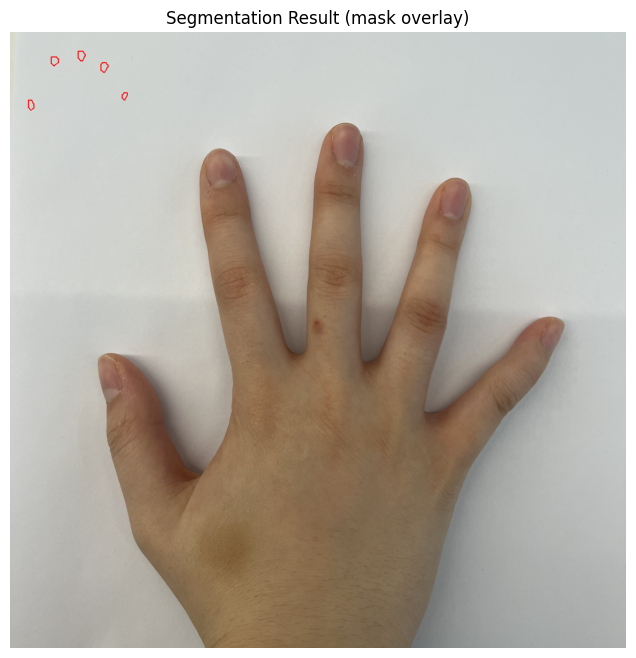

✔ 출력 저장 완료 → /content/test_output


In [20]:
import numpy as np
import cv2
from PIL import Image
import pillow_heif
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os

# ----------------------------------------------------
# 1) 설정
# ----------------------------------------------------
test_img_path = "/content/IMG_8881.heic"   # 테스트할 아이폰 사진
model_path = "/content/runs/segment/warmup640/weights/best.pt"   # 학습된 YOLO11 세그멘테이션 모델
save_dir = "/content/test_output"          # 출력 저장 폴더
os.makedirs(save_dir, exist_ok=True)

# ----------------------------------------------------
# 2) HEIC 이미지 읽기
# ----------------------------------------------------
pillow_heif.register_heif_opener()
img_pil = Image.open(test_img_path)
img = np.array(img_pil)   # numpy RGB

# ----------------------------------------------------
# 3) 모델 로드
# ----------------------------------------------------
model = YOLO(model_path)

# ----------------------------------------------------
# 4) 추론 실행
# ----------------------------------------------------
results = model(img, imgsz=640, conf=0.3)
res = results[0]

# ----------------------------------------------------
# 5) 결과 확인
# ----------------------------------------------------
if res.masks is None:
    print("❌ 세그멘테이션 실패: 손톱을 찾지 못했습니다.")
else:
    print(f"✔ 감지된 손톱 개수: {len(res.masks.data)}")

# ----------------------------------------------------
# 6) 마스크 시각화
# ----------------------------------------------------
mask_overlay = img.copy()

for i, mask in enumerate(res.masks.data):
    m = mask.cpu().numpy().astype(np.uint8)
    contours, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(mask_overlay, contours, -1, (255, 0, 0), 3)

plt.figure(figsize=(8, 8))
plt.imshow(mask_overlay)
plt.title("Segmentation Result (mask overlay)")
plt.axis("off")
plt.savefig(f"{save_dir}/overlay_result.png")
plt.show()

# ----------------------------------------------------
# 7) 마스크 개별 저장 (깨끗한 흰색 mask)
# ----------------------------------------------------
for idx, mask in enumerate(res.masks.data):
    m = (mask.cpu().numpy() * 255).astype(np.uint8)
    cv2.imwrite(f"{save_dir}/mask_{idx}.png", m)

print(f"✔ 출력 저장 완료 → {save_dir}")


#전체


In [21]:
yaml_path = "/content/nail_dataset/data.yaml"

text = """
train: /content/nail_dataset/train
val: /content/nail_dataset/valid
test: /content/nail_dataset/test

nc: 1
names: ['nail']
"""

with open(yaml_path, "w") as f:
    f.write(text)

print("✔ data.yaml 생성 완료:", yaml_path)


✔ data.yaml 생성 완료: /content/nail_dataset/data.yaml


In [22]:
!yolo settings runs_dir="/content/drive/MyDrive/최종프로젝트/손톱세그멘테이션_전체학습결과"

✅ Updated 'runs_dir=/content/drive/MyDrive/최종프로젝트/손톱세그멘테이션_전체학습결과'
JSONDict("/root/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/content/datasets",
  "weights_dir": "weights",
  "runs_dir": "/content/drive/MyDrive/최종프로젝트/손톱세그멘테이션_전체학습결과",
  "uuid": "569f3ba64b326db489132663f79cd37279811de477381b83ac131e6cdd129cbb",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": false,
  "wandb": false,
  "vscode_msg": true,
  "openvino_msg": true
}
💡 Learn more about Ultralytics Settings at https://docs.ultralytics.com/quickstart/#ultralytics-settings


In [23]:
!nvidia-smi

Tue Nov 18 17:13:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P0             32W /   70W |     324MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [24]:
!yolo segment train \
  data=/content/nail_dataset/data.yaml \
  model=yolo11s-seg.pt \
  epochs=100 \
  imgsz=640 \
  batch=8 \
  device=0 \
  save_period=5 \
  warmup_epochs=5

print("🔥 YOLO11s Segmentation(Baseline+Warmup) 학습 완료!")


Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/nail_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, po

#테스트


0: 640x640 5 nails, 29.8ms
Speed: 4.9ms preprocess, 29.8ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 640)
🎯 탐지된 nail 개수: 5


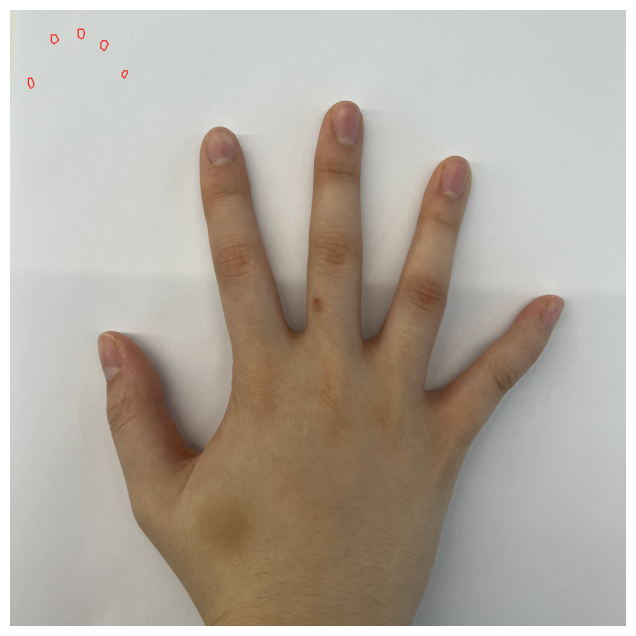

In [25]:
import numpy as np
import cv2
from PIL import Image
import pillow_heif
from ultralytics import YOLO
import matplotlib.pyplot as plt

# 1) HEIC 읽기 설정
pillow_heif.register_heif_opener()

# 2) 이미지 로드
img_path = "/content/IMG_8881.heic"  # 테스트할 아이폰 이미지
img_pil = Image.open(img_path)
img = np.array(img_pil)   # RGB numpy 이미지

# 3) 모델 로드 (100 epoch 학습된 best.pt)
model_path = "/content/drive/MyDrive/최종프로젝트/손톱세그멘테이션_전체학습결과/segment/train/weights/best.pt"
model = YOLO(model_path)

# 4) 추론
results = model(img, imgsz=640)

# 5) 결과
res = results[0]

if res.masks is None:
    print("❌ 세그멘테이션 없음 (no detections)")
else:
    print(f"🎯 탐지된 nail 개수: {len(res.masks.data)}")

    # 6) 폴리곤 시각화
    mask_img = img.copy()

    for mask in res.masks.data:
        m = mask.cpu().numpy().astype(np.uint8)
        contours, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(mask_img, contours, -1, (255, 0, 0), 3)

    plt.figure(figsize=(8,8))
    plt.imshow(mask_img)
    plt.axis("off")
    plt.show()



0: 640x640 5 nails, 29.8ms
Speed: 4.1ms preprocess, 29.8ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)


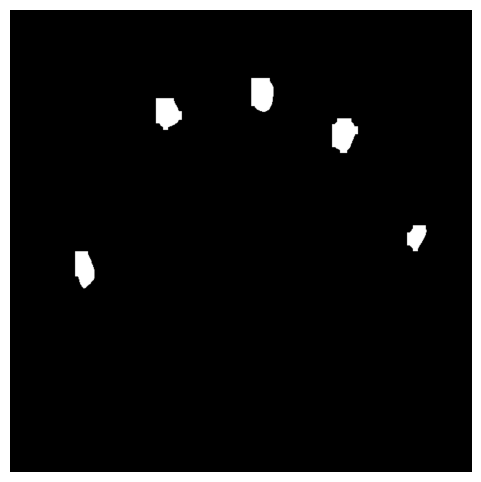

✔ 흰/검 마스크 저장 완료: /content/nail_mask_binary.png


In [27]:
import numpy as np
import cv2
from PIL import Image
import pillow_heif
from ultralytics import YOLO
import matplotlib.pyplot as plt

# HEIC 지원
pillow_heif.register_heif_opener()

# 원본 이미지 로드
img_path = "/content/IMG_8881.heic"
img_pil = Image.open(img_path)
img = np.array(img_pil)

# 모델 로드
model_path = "/content/drive/MyDrive/최종프로젝트/손톱세그멘테이션_전체학습결과/segment/train/weights/best.pt"
model = YOLO(model_path)

# 추론
results = model(img, imgsz=640)
res = results[0]

if res.masks is None:
    print("❌ 세그멘테이션 없음")
else:
    h, w = img.shape[:2]
    final_mask = np.zeros((h, w), dtype=np.uint8)   # 원본 크기로 생성

    for mask in res.masks.data:
        m = mask.cpu().numpy().astype(np.uint8)  # (640,640) 0/1 mask

        # ⭐ YOLO mask → 원본 이미지 크기로 upscale
        m_resized = cv2.resize(m, (w, h), interpolation=cv2.INTER_NEAREST)

        # 합쳐서 하나의 마스크 생성
        final_mask = np.maximum(final_mask, m_resized * 255)

    # 시각화
    plt.figure(figsize=(6, 6))
    plt.imshow(final_mask, cmap="gray")
    plt.axis("off")
    plt.show()

    # 저장
    save_path = "/content/nail_mask_binary.png"
    cv2.imwrite(save_path, final_mask)
    print("✔ 흰/검 마스크 저장 완료:", save_path)



0: 640x640 5 nails, 29.8ms
Speed: 4.3ms preprocess, 29.8ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)


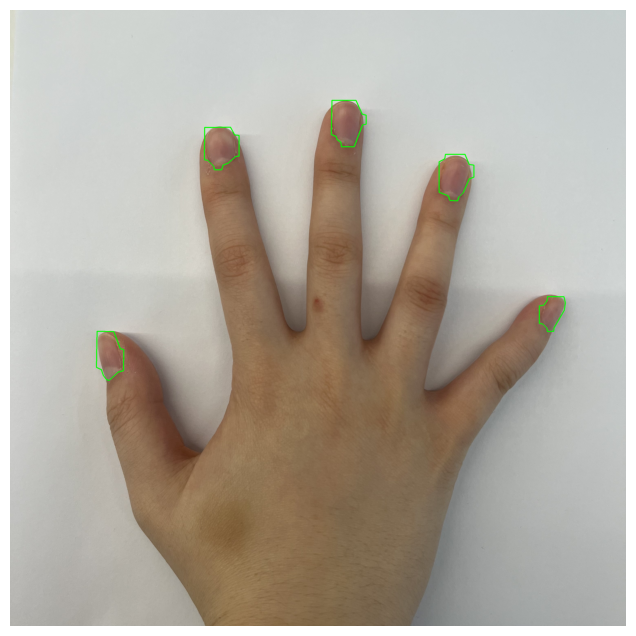

✔ 매끄러운 손톱 폴리곤 생성 완료!


In [28]:
import numpy as np
import cv2
from PIL import Image
import pillow_heif
from ultralytics import YOLO
import matplotlib.pyplot as plt

# 1) HEIC 읽기 설정
pillow_heif.register_heif_opener()

# 2) 이미지 로드
img_path = "/content/IMG_8881.heic"
img_pil = Image.open(img_path)
img = np.array(img_pil)   # RGB

# 3) YOLO 세그멘테이션 모델 로드
model = YOLO("/content/runs/segment/warmup640/weights/best.pt")

# 4) 추론
results = model(img, imgsz=640)
res = results[0]

# -------------------------------
# 5) YOLO mask → 부드러운 곡선 polygon으로 변환
# -------------------------------

h, w = img.shape[:2]
visual = img.copy()

if res.masks is None:
    print("❌ 감지된 손톱 없음")
else:
    # YOLO mask는 640×640 → 원본 크기로 리사이즈 필요
    for m in res.masks.data:
        m = m.cpu().numpy().astype(np.uint8) * 255
        m = cv2.resize(m, (w, h))

        # --- (A) 노이즈 제거 & 매끄럽게 만들기 ---
        m = cv2.GaussianBlur(m, (7, 7), 0)     # 부드럽게
        _, m = cv2.threshold(m, 80, 255, cv2.THRESH_BINARY)  # 깔끔한 이진화

        kernel = np.ones((5,5), np.uint8)
        m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, kernel, iterations=2)
        m = cv2.morphologyEx(m, cv2.MORPH_OPEN, kernel, iterations=1)

        # --- (B) 곡선 polygon 추출 ---
        contours, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        for cnt in contours:

            # 곡선 다듬기: epsilon이 작을수록 디테일 유지, 크면 더 부드러움
            epsilon = 0.007 * cv2.arcLength(cnt, True)
            poly = cv2.approxPolyDP(cnt, epsilon, True)

            # 결과 그리기
            cv2.drawContours(visual, [poly], -1, (0,255,0), 3)

# -------------------------------
# 6) 시각화
# -------------------------------
plt.figure(figsize=(8,8))
plt.imshow(visual)
plt.axis("off")
plt.show()

print("✔ 매끄러운 손톱 폴리곤 생성 완료!")


In [29]:
# mask를 매끄럽게 보정
m = cv2.resize(m, (w, h))
m = cv2.GaussianBlur(m, (9, 9), 0)

# Otsu 자동 임계값으로 가장 정확한 분리
_, m = cv2.threshold(m, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# morphology로 깔끔하게 정리
kernel = np.ones((7,7), np.uint8)
m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, kernel, iterations=3)
m = cv2.morphologyEx(m, cv2.MORPH_OPEN, kernel, iterations=2)

# 경계부 부드럽게
m = cv2.GaussianBlur(m, (5, 5), 0)


In [30]:
import scipy.interpolate as si

def smooth_contour(cnt, smooth_factor=0.001):
    cnt = cnt.squeeze()
    x = cnt[:, 0]
    y = cnt[:, 1]

    # 순환(폐곡선) curve smoothing 위한 padding
    x = np.r_[x, x[0]]
    y = np.r_[y, y[0]]

    t = np.arange(len(x))

    # B-spline 피팅
    spl_x = si.UnivariateSpline(t, x, s=smooth_factor)
    spl_y = si.UnivariateSpline(t, y, s=smooth_factor)

    # 곡선 300점으로 매끄럽게 sampling
    t_new = np.linspace(0, len(x)-1, 300)
    x_smooth = spl_x(t_new)
    y_smooth = spl_y(t_new)

    smooth_cnt = np.vstack((x_smooth, y_smooth)).T.astype(np.int32)
    return smooth_cnt


In [31]:
for cnt in contours:
    smooth_cnt = smooth_contour(cnt, smooth_factor=500)
    cv2.drawContours(visual, [smooth_cnt], -1, (0,255,0), 3)



0: 640x640 5 nails, 46.3ms
Speed: 13.6ms preprocess, 46.3ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 640)
✔ YOLO 손톱 검출 완료


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128133 (\N{NAIL POLISH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


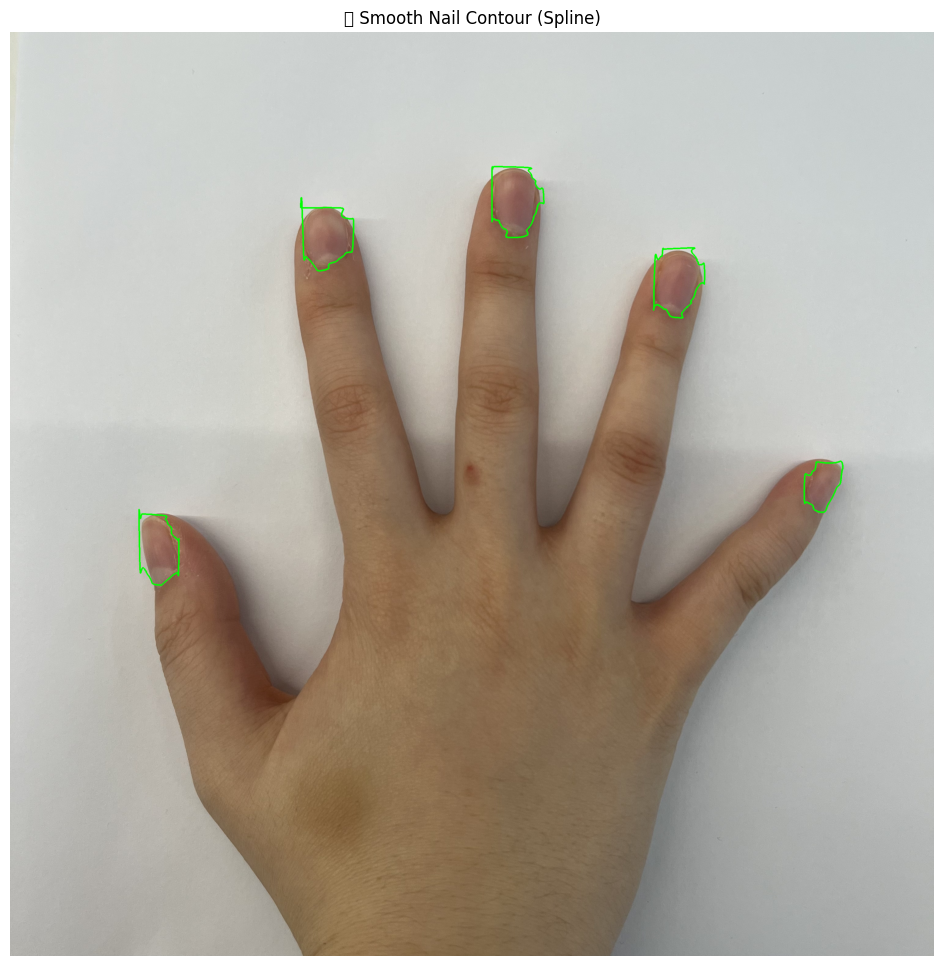

✨ 손톱 곡선 생성 완료!


In [34]:
import numpy as np
import cv2
from PIL import Image
import pillow_heif
from ultralytics import YOLO
import matplotlib.pyplot as plt
import scipy.interpolate as si

# ======================================================
# 1) B-Spline 기반 곡선 smoothing 함수
# ======================================================
def smooth_contour(cnt, smooth_factor=1000):
    cnt = cnt.squeeze()

    # x, y 좌표 분리
    x = cnt[:, 0]
    y = cnt[:, 1]

    # 폐곡선이므로 첫 점을 반복
    x = np.r_[x, x[0]]
    y = np.r_[y, y[0]]

    t = np.arange(len(x))

    # B-spline 피팅
    spl_x = si.UnivariateSpline(t, x, s=smooth_factor)
    spl_y = si.UnivariateSpline(t, y, s=smooth_factor)

    # 300개 점으로 곡선 sampling
    t_new = np.linspace(0, len(x) - 1, 300)
    x_s = spl_x(t_new)
    y_s = spl_y(t_new)

    smooth_cnt = np.vstack((x_s, y_s)).T.astype(np.int32)
    return smooth_cnt

# ======================================================
# 2) 이미지 로드 (HEIC 지원)
# ======================================================
pillow_heif.register_heif_opener()

img_path = "/content/IMG_8881.heic"
img_pil = Image.open(img_path)
img = np.array(img_pil)  # RGB

h, w = img.shape[:2]

# ======================================================
# 3) YOLO11 Segmentation 모델 로드
# ======================================================
model = YOLO("/content/runs/segment/warmup640/weights/best.pt")

# 추론
results = model(img, imgsz=640)
res = results[0]

if res.masks is None:
    print("❌ 손톱을 찾지 못했어!")
else:
    print("✔ YOLO 손톱 검출 완료")


# ======================================================
# 4) YOLO mask 후처리 + 스플라인 부드러운 윤곽 생성
# ======================================================
final_mask = np.zeros((h, w), dtype=np.uint8)
visual = img.copy()

for mask in res.masks.data:
    # YOLO mask (0/1) → 0/255로 변환 후 원본크기 복원
    m = mask.cpu().numpy().astype(np.uint8)
    m = cv2.resize(m, (w, h))
    m = m * 255

    # ✨ 노이즈 제거 + 경계 smoothing
    m = cv2.GaussianBlur(m, (9, 9), 0)
    _, m = cv2.threshold(m, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((7, 7), np.uint8)
    m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, kernel, iterations=3)
    m = cv2.morphologyEx(m, cv2.MORPH_OPEN, kernel, iterations=2)

    final_mask = np.maximum(final_mask, m)

# ======================================================
# 5) 부드러운 손톱 곡선 생성 (Spline)
# ======================================================
contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

smooth_visual = img.copy()

for cnt in contours:
    if len(cnt) < 10:
        continue

    smooth_cnt = smooth_contour(cnt, smooth_factor=800)  # 곡선 부드러움 정도 조절
    cv2.drawContours(smooth_visual, [smooth_cnt], -1, (0, 255, 0), 3)


# ======================================================
# 6) 결과 시각화
# ======================================================
plt.figure(figsize=(12, 12))
plt.imshow(smooth_visual)
plt.title("💅 Smooth Nail Contour (Spline)")
plt.axis("off")
plt.show()

print("✨ 손톱 곡선 생성 완료!")
